In [722]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
import seaborn as sns
import csv
import re
import keras
from matplotlib import pyplot as plt
from sklearn import ensemble, cross_validation, learning_curve, metrics , tree, naive_bayes, utils
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import load_digits, load_breast_cancer, load_iris
from sklearn.cross_validation import cross_val_score, KFold, LeaveOneOut, ShuffleSplit, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier, BaggingRegressor
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans, AgglomerativeClustering, FeatureAgglomeration
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
matplotlib.style.use('ggplot')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [136]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [137]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Сделаем "Sex" числовым признаком - male -> 1, female -> 0

In [138]:
replacement = {'male' : 1, 'female' : 0}
sex_int_df = pd.DataFrame(list(map(lambda sex_person: replacement[sex_person], df_train['Sex'])), columns=['Sex'], dtype=int)
sex_int_df_test = pd.DataFrame(list(map(lambda sex_person: replacement[sex_person], df_test['Sex'])), columns=['Sex'], dtype=int)

In [139]:
df_train = pd.concat([df_train.drop('Sex', axis=1), sex_int_df], axis=1)
df_test = pd.concat([df_test.drop('Sex', axis=1), sex_int_df_test], axis=1)

In [140]:
df_train.head(891)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,1
5,6,0,3,"Moran, Mr. James",NaN,0,0,330877,8.4583,NaN,Q,1
6,7,0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,E46,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,NaN,S,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,NaN,S,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,30.0708,NaN,C,0


In [141]:
df_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.042939
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.543351
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.131900
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.093254
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.114631
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.245489
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182333
Sex,0.042939,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,1.000000


Посчитаем процент пропусков

In [142]:
print("TRAIN")
for column in df_train.columns:
    print( round(1 - len(df_train[column].dropna(axis=0)) / len(df_train[column]), 2) * 100 ,"% nan in ", column )
print("TEST")
for column in df_test.columns:
    print( round(1 - len(df_test[column].dropna(axis=0)) / len(df_test[column]), 2) * 100 ,"% nan in ", column )

TRAIN
0.0 % nan in  PassengerId
0.0 % nan in  Survived
0.0 % nan in  Pclass
0.0 % nan in  Name
20.0 % nan in  Age
0.0 % nan in  SibSp
0.0 % nan in  Parch
0.0 % nan in  Ticket
0.0 % nan in  Fare
77.0 % nan in  Cabin
0.0 % nan in  Embarked
0.0 % nan in  Sex
TEST
0.0 % nan in  PassengerId
0.0 % nan in  Pclass
0.0 % nan in  Name
21.0 % nan in  Age
0.0 % nan in  SibSp
0.0 % nan in  Parch
0.0 % nan in  Ticket
0.0 % nan in  Fare
78.0 % nan in  Cabin
0.0 % nan in  Embarked
0.0 % nan in  Sex


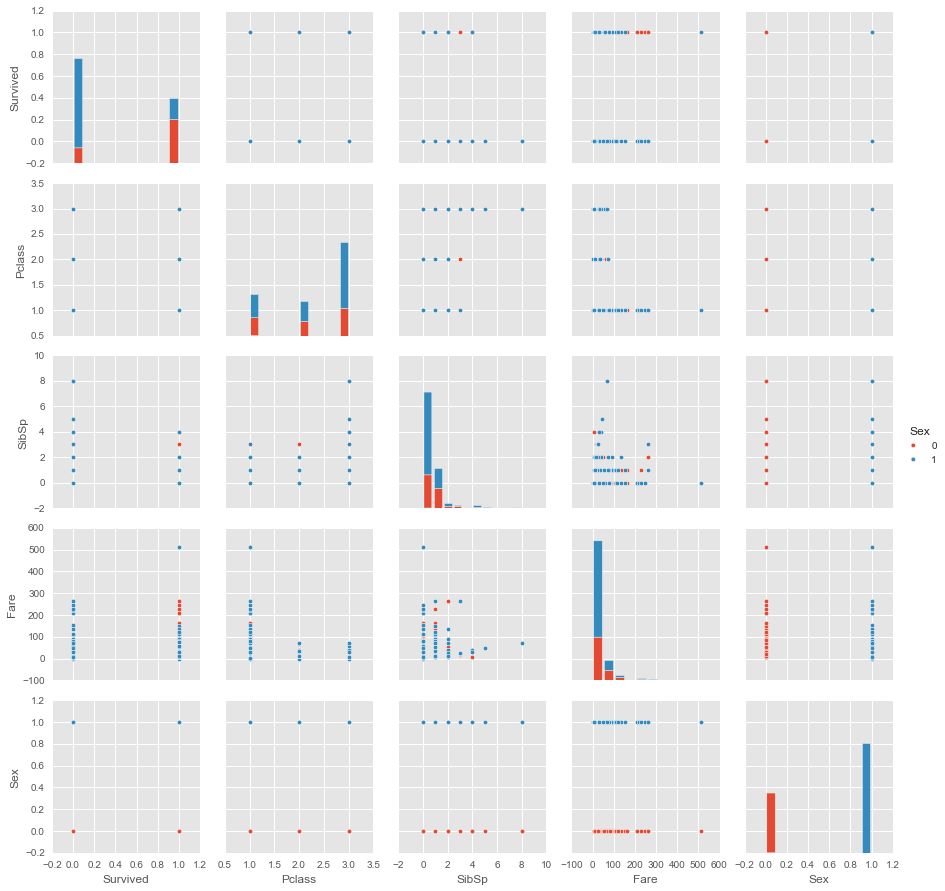

In [143]:
sns.pairplot(df_train[['Survived', 'Pclass', 'SibSp', 'Fare', 'Sex']], diag_kind='hist', hue="Sex") 

Каждое значение Name имеет вид Second Name, title First name. Titles = ['Mr.', 'Mrs', 'Miss.', 'Master.']. Добавим каждому человеку метку 'title' с титулом

In [144]:
#для начала найдет титулы пропущенных значений в тренировочной и тестовой выборках
df_nan_age_train = df_train[np.isnan(df_train['Age'])]
df_nan_age_test = df_test[np.isnan(df_test['Age'])]
nan_titles_train = []
nan_titles_test = []
for name in df_nan_age_train['Name'].values:
    nan_titles_train.append((name.split(',')[1]).split()[0])
for name in df_nan_age_test['Name'].values:
    nan_titles_test.append((name.split(',')[1]).split()[0])
print(pd.unique(nan_titles_train))
print(pd.unique(nan_titles_test))
print(pd.unique(np.concatenate((nan_titles_train, nan_titles_test), axis=0)))

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Dr.']
['Mr.' 'Mrs.' 'Miss.' 'Ms.' 'Master.']
['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Dr.' 'Ms.']


In [145]:
# нужно проанализировать только ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Dr.' 'Ms.']
titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr.', 'Ms.']

In [146]:
print(len(titles))
#для тренировочных
title_col = []
paranormal_names = []
names_train = df_train['Name'].values
names_test = df_test['Name'].values
names = np.concatenate((names_train, names_test))
cnt = 0
is_train = True
for name in names:
    if cnt >= len(names_train):
        is_train = False

    name_yet_append = False
    for title in titles:
        if title in name:
            name_yet_append = True
            title_col.append(title)
            
    if name_yet_append == False:
        paranormal_names.append(name)
        # 0 - PassId, 1 - Survived, 2 - Pclass, 3 - Name, 4 - Age, 11 - Sex
        if is_train:
            if df_train[df_train['Name'] == name].values[0][11] == 1:
                title_col.append('Mr.')
            else:
                title_col.append('Mrs.')
        # 0 - PassId, 1 - Pclass, 2 - Name, 3 - Age, 10 - Sex
        else:
            if df_test[df_test['Name'] == name].values[0][10] == 1:
                title_col.append('Mr.')
            else:
                title_col.append('Mrs.')

    cnt += 1
        
print(len(title_col), len(names))
title_train = title_col[:len(names_train)]
title_test = title_col[len(names_train):]
#паранормальные имена - имена капитана и юнкера корабля => поставим им Mr.

6
1309 1309


In [147]:
title_train = np.array(title_train)
title_test = np.array(title_test)
print(title_test.shape, title_train.shape)
title_train_df = pd.DataFrame(data=title_train, columns=['Title'])
title_test_df = pd.DataFrame(data=title_test, columns=['Title'])

(418,) (891,)


In [148]:
df_train = pd.concat([df_train, title_train_df], axis=1)
df_test = pd.concat([df_test, title_test_df], axis=1)

In [149]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex,Title
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,0,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,0,Mrs.
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,1,Mr.


In [151]:
#теперь имена нам не понадобятся:
df_train = df_train.drop('Name', axis=1)
df_test = df_test.drop('Name', axis=1)

In [152]:
df_train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex,Title
0,1,0,3,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr.
1,2,1,1,38.0,1,0,PC 17599,71.2833,C85,C,0,Mrs.
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss.
3,4,1,1,35.0,1,0,113803,53.1000,C123,S,0,Mrs.
4,5,0,3,35.0,0,0,373450,8.0500,NaN,S,1,Mr.


In [172]:
print( pd.value_counts(df_train['Title']) )
print( pd.value_counts(df_test['Title']) )
print( round((df_test[df_test['Title'] == 'Ms.'])['Age'].mean(), 1) )

Mr.        531
Miss.      182
Mrs.       130
Master.     40
Dr.          7
Ms.          1
Name: Title, dtype: int64
Mr.        244
Miss.       78
Mrs.        73
Master.     21
Dr.          1
Ms.          1
Name: Title, dtype: int64
nan


In [175]:
mean_age_in_title = dict.fromkeys(titles, 0)
for title in titles:
    mean_age_in_title[title] = round((df_train[df_train['Title'] == title])['Age'].mean(), 1)
print (mean_age_in_title)

{'Ms.': 28.0, 'Mr.': 32.9, 'Master.': 4.6, 'Mrs.': 35.7, 'Dr.': 42.0, 'Miss.': 21.8}


In [203]:
# теперь заполняем пропуски в возрасте
age_title_train = df_train[['Age', 'Title']].values
age_title_test = df_test[['Age', 'Title']].values
age_without_nan_train = pd.DataFrame(
    data=list(map(lambda row: mean_age_in_title[row[1]] if np.isnan(row[0]) else row[0], age_title_train)), 
    columns=['Age'])
age_without_nan_test = pd.DataFrame(
    data=list(map(lambda row: mean_age_in_title[row[1]] if np.isnan(row[0]) else row[0], age_title_test)), 
    columns=['Age'])

In [208]:
df_train = df_train.drop('Age', axis=1)
df_test = df_test.drop('Age', axis=1)
df_train = pd.concat([df_train, age_without_nan_train], axis=1)
df_test = pd.concat([df_test, age_without_nan_test], axis=1)

In [209]:
df_train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex,Title,Age
0,1,0,3,1,0,A/5 21171,7.2500,NaN,S,1,Mr.,22.0
1,2,1,1,1,0,PC 17599,71.2833,C85,C,0,Mrs.,38.0
2,3,1,3,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss.,26.0
3,4,1,1,1,0,113803,53.1000,C123,S,0,Mrs.,35.0
4,5,0,3,0,0,373450,8.0500,NaN,S,1,Mr.,35.0


In [210]:
print("TRAIN")
for column in df_train.columns:
    print( round(1 - len(df_train[column].dropna(axis=0)) / len(df_train[column]), 2) * 100 ,"% nan in ", column )
print("TEST")
for column in df_test.columns:
    print( round(1 - len(df_test[column].dropna(axis=0)) / len(df_test[column]), 2) * 100 ,"% nan in ", column )

TRAIN
0.0 % nan in  PassengerId
0.0 % nan in  Survived
0.0 % nan in  Pclass
0.0 % nan in  SibSp
0.0 % nan in  Parch
0.0 % nan in  Ticket
0.0 % nan in  Fare
77.0 % nan in  Cabin
0.0 % nan in  Embarked
0.0 % nan in  Sex
0.0 % nan in  Title
0.0 % nan in  Age
TEST
0.0 % nan in  PassengerId
0.0 % nan in  Pclass
0.0 % nan in  SibSp
0.0 % nan in  Parch
0.0 % nan in  Ticket
0.0 % nan in  Fare
78.0 % nan in  Cabin
0.0 % nan in  Embarked
0.0 % nan in  Sex
0.0 % nan in  Title
0.0 % nan in  Age


//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


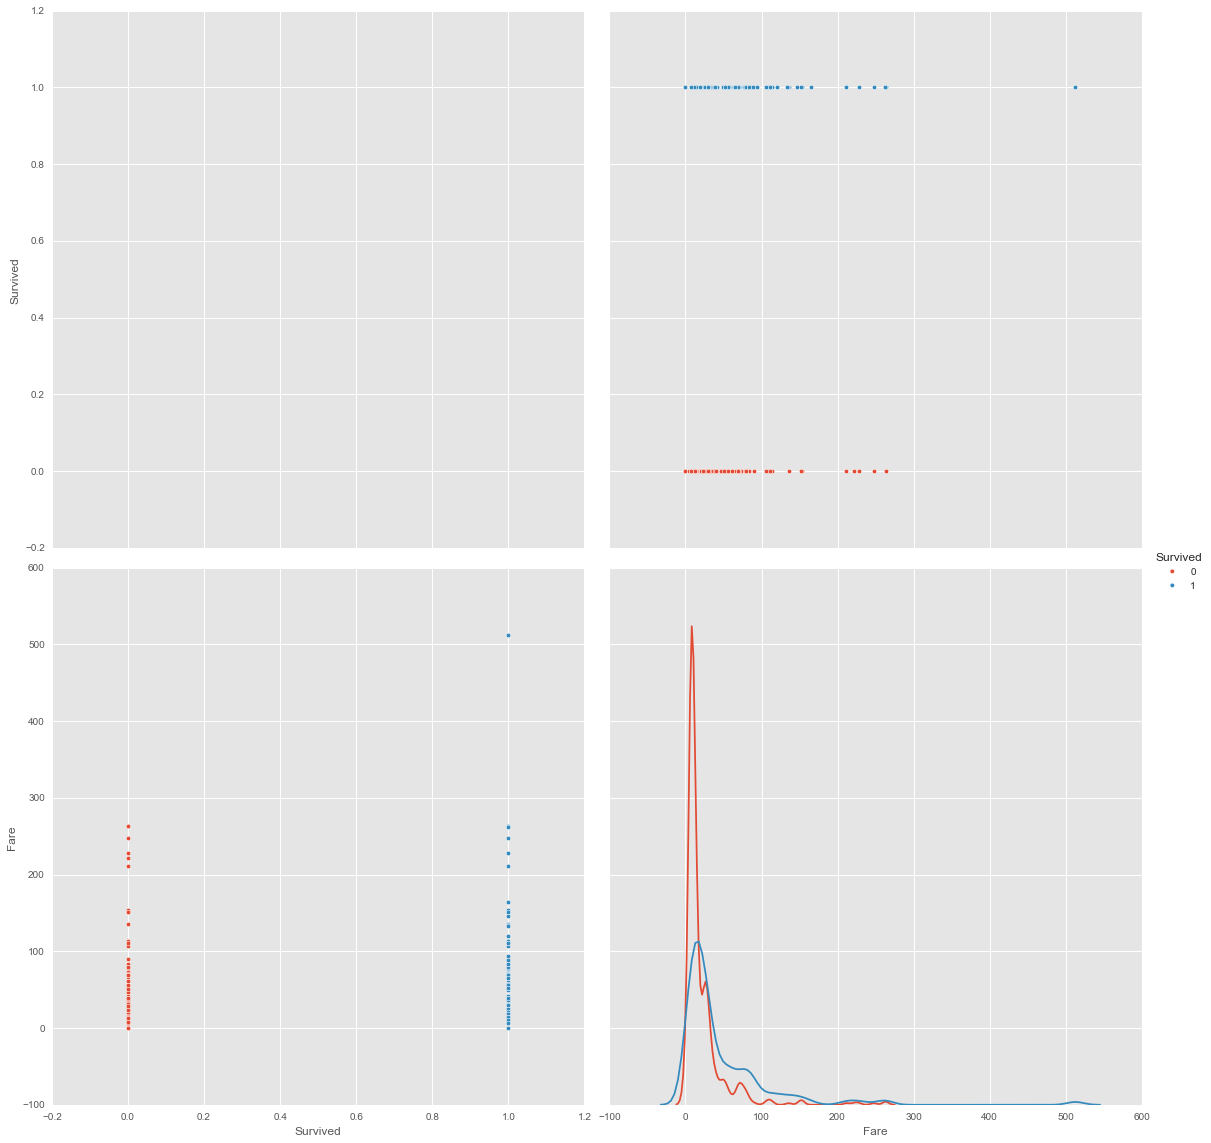

In [218]:
#Рассмотрим цену на билеты
sns.pairplot(df_train[['Survived', 'Fare']], size=8, hue='Survived', diag_kind='kde')

Mean =  32.2042079685746 
 Median =  14.4542
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
15


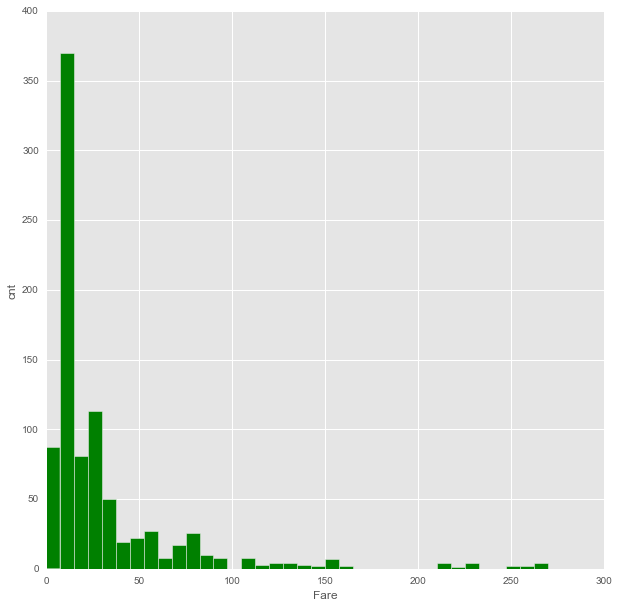

In [239]:
plt.figure(figsize=(10, 10))
plt.hist(df_train['Fare'], bins=40, color='green',  range=(0, 300));
plt.ylabel("cnt")
plt.xlabel("Fare")
print('Mean = ', np.mean(df_train['Fare']), '\n', 'Median = ', np.median(df_train['Fare']) )
cnt = 0

In [240]:
# заменяем билеты с ценой 0 на среднюю цену
fare_train = df_train['Fare'].values
fare_test = df_test['Fare'].values
fare_mean = np.mean(fare_train)

In [360]:
fare_train_new = list(map(lambda fare: fare_mean if fare == 0 or np.isnan(fare) else fare, fare_train))
fare_test_new = list(map(lambda fare: fare_mean if fare == 0 or np.isnan(fare) else fare, fare_test))

In [361]:
fare_df_train = pd.DataFrame(data=fare_train_new, columns=['Fare'], dtype=float)
fare_df_test = pd.DataFrame(data=fare_test_new, columns=['Fare'], dtype=float)

In [362]:
df_train = df_train.drop('Fare', axis=1)
df_test = df_test.drop('Fare', axis=1)
df_train = pd.concat([df_train, fare_df_train], axis=1)
df_test = pd.concat([df_test, fare_df_test], axis=1)

Mean =  32.74636635188393 
 Median =  15.1


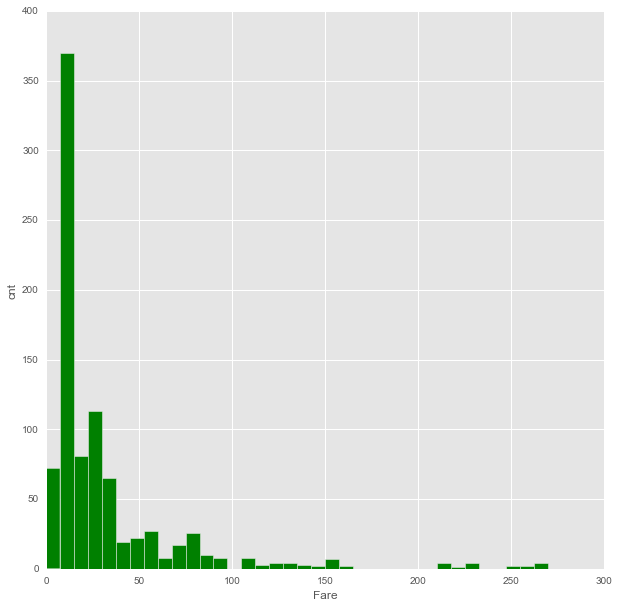

In [363]:
plt.figure(figsize=(10, 10))
plt.hist(df_train['Fare'], bins=40, color='green',  range=(0, 300));
plt.ylabel("cnt")
plt.xlabel("Fare")
print('Mean = ', np.mean(df_train['Fare']), '\n', 'Median = ', np.median(df_train['Fare']) )

In [364]:
# все-таки обновлю колонку title, используя все титулы, а не только самые популярные

In [365]:
upd_titles = []
for name in names:
    upd_titles.append(name.split('.')[0].split()[-1] + '.')
titles = list(pd.value_counts(upd_titles).keys())
print(titles)

['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Dr.', 'Rev.', 'Col.', 'Ms.', 'Major.', 'Mlle.', 'Capt.', 'Jonkheer.', 'Lady.', 'Mme.', 'Sir.', 'Countess.', 'Don.', 'Dona.']


In [366]:
upd_arr_titles = []
for name in names:
    for title in titles:
        if title in name:
            if title == 'Dona.':
                upd_arr_titles.append('Don.')
            else:
                upd_arr_titles.append(title)
upd_arr_titles_train = upd_arr_titles[:len(names_train)]
upd_arr_titles_test = upd_arr_titles[len(names_train):]
title_train_df = pd.DataFrame(data=upd_arr_titles_train, columns=['Title'])
title_test_df = pd.DataFrame(data=upd_arr_titles_test, columns=['Title'])
df_train = df_train.drop('Title', axis=1)
df_test = df_test.drop('Title', axis=1)
df_train = pd.concat([df_train, title_train_df], axis=1)
df_test = pd.concat([df_test, title_test_df], axis=1)

In [367]:
df_train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Ticket,Cabin,Embarked,Sex,Age,Fare,Title
0,1,0,3,1,0,A/5 21171,NaN,S,1,22.0,7.2500,Mr.
1,2,1,1,1,0,PC 17599,C85,C,0,38.0,71.2833,Mrs.
2,3,1,3,0,0,STON/O2. 3101282,NaN,S,0,26.0,7.9250,Miss.
3,4,1,1,1,0,113803,C123,S,0,35.0,53.1000,Mrs.
4,5,0,3,0,0,373450,NaN,S,1,35.0,8.0500,Mr.


In [368]:
features_for_algo = ['Pclass', 'SibSp', 'Parch', 'Sex', 'Age', 'Fare', 'Title']
df_train_end = df_train[features_for_algo]
df_test_end = df_test[features_for_algo]

In [369]:
y = df_train['Survived']

In [370]:
print("TRAIN")
for column in df_train_end.columns:
    print( round(1 - len(df_train_end[column].dropna(axis=0)) / len(df_train_end[column]), 10) * 100 ,"% nan in ", column )
print("TEST")
for column in df_test_end.columns:
    print( round(1 - len(df_test_end[column].dropna(axis=0)) / len(df_test_end[column]), 10) * 100 ,"% nan in ", column )

TRAIN
0.0 % nan in  Pclass
0.0 % nan in  SibSp
0.0 % nan in  Parch
0.0 % nan in  Sex
0.0 % nan in  Age
0.0 % nan in  Fare
0.0 % nan in  Title
TEST
0.0 % nan in  Pclass
0.0 % nan in  SibSp
0.0 % nan in  Parch
0.0 % nan in  Sex
0.0 % nan in  Age
0.0 % nan in  Fare
0.0 % nan in  Title


In [371]:
df_train_end.head(5)

,Pclass,SibSp,Parch,Sex,Age,Fare,Title
0,3,1,0,1,22.0,7.2500,Mr.
1,1,1,0,0,38.0,71.2833,Mrs.
2,3,0,0,0,26.0,7.9250,Miss.
3,1,1,0,0,35.0,53.1000,Mrs.
4,3,0,0,1,35.0,8.0500,Mr.


In [494]:
X_1 = df_train_end.drop(['Title'], axis=1).values
X_kaggle_test = df_test_end.drop(['Title'], axis=1).values

In [495]:
encoder = DictVectorizer(sparse=False)
Title_train = df_train['Title']
Title_test = df_test['Title']

In [496]:
print(titles, Title_train.shape)

['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Dr.', 'Rev.', 'Col.', 'Ms.', 'Major.', 'Mlle.', 'Capt.', 'Jonkheer.', 'Lady.', 'Mme.', 'Sir.', 'Countess.', 'Don.', 'Dona.'] (891,)


In [635]:
family_df_train = pd.DataFrame(df_train_end['Parch'] + df_train_end['SibSp'], columns=['Family'])
df_train_end_end = pd.concat([df_train_end, family_df_train], axis=1)
family_df_test = pd.DataFrame(df_test_end['Parch'] + df_test_end['SibSp'], columns=['Family'])
df_test_end_end = pd.concat([df_test_end, family_df_test], axis=1)
df_train_end_end = df_train_end_end.drop(['SibSp', 'Parch'], axis=1)
df_test_end_end = df_test_end_end.drop(['SibSp', 'Parch'], axis=1)

In [638]:
df_train_end_end = df_train_end_end.drop('Title', axis=1)
df_test_end_end = df_test_end_end.drop('Title', axis=1)

In [648]:
X_1 = df_train_end_end.values
X_kaggle_test_1 = df_test_end_end.values

In [709]:
#survived - 1, title - -1
cnt_of_titles = dict.fromkeys(list(pd.value_counts(df_train_end['Title']).keys()), 0)
for title in df_train_end['Title'].values:
    cnt_of_titles[title] += 1
unpopular_titles = dict.fromkeys(map(lambda pair: pair[0], list(filter(lambda title_cnt: title_cnt[1] < 10, cnt_of_titles.items()))), 0)
unpopular_titles['Dona.'] = 1
new_titles_train = []
new_titles_test = []
for title in df_train_end['Title'].values:
    if title in unpopular_titles:
        new_titles_train.append('unpopular')
    else:
        new_titles_train.append(title)
for title in df_test_end['Title'].values:
    if title in unpopular_titles:
        new_titles_test.append('unpopular')
    else:
        new_titles_test.append(title)

In [710]:
replacement = dict.fromkeys(list(pd.value_counts(new_titles_train).keys()))

In [711]:
cnt = 0
for title in replacement:
    replacement[title] = cnt
    cnt += 1
replacement

{'Master.': 0, 'Miss.': 3, 'Mr.': 4, 'Mrs.': 2, 'unpopular': 1}

In [712]:
titles_train_oh = np.zeros_like([0 for i in range(len(new_titles_train) * len(replacement))])
titles_train_oh = titles_train_oh.reshape((len(new_titles_train), len(replacement)))
titles_test_oh = np.zeros_like([0 for i in range(len(new_titles_test) * len(replacement))])
titles_test_oh = titles_test_oh.reshape((len(new_titles_test), len(replacement)))

In [713]:
for cnt in range(len(new_titles_train)):
    place = replacement[new_titles_train[cnt]]
    titles_train_oh[cnt][place] = 1
for cnt in range(len(new_titles_test)):
    place = replacement[new_titles_test[cnt]]
    titles_test_oh[cnt][place] = 1
titles_train_oh

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       ..., 
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [714]:
X = np.concatenate((X_1, titles_train_oh), axis=1)
X_kaggle = np.concatenate((X_kaggle_test_1, titles_test_oh), axis=1)
print(X.shape, X_kaggle.shape)

(891, 10) (418, 10)


In [725]:
cv_kfold = KFold(n=X.shape[0], n_folds=5, shuffle=True, random_state=42)

In [759]:
rf_clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [770]:
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
param_grid = {
    'max_depth': np.linspace(1, 15, 15, dtype=int),
    'n_estimators' : np.linspace(5, 100, 50, dtype=int)
}
optimizer = GridSearchCV(rf_clf, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=cv_kfold)

In [771]:
%%time
optimizer.fit(X, y)

KeyboardInterrupt: 

In [486]:
optimizer.best_score_

0.84175084175084181

In [765]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.get_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': -1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}

In [766]:
xgb_optim = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=cv_kfold)

In [767]:
%%time
xgb_optim.fit(X, y)

CPU times: user 4.49 s, sys: 177 ms, total: 4.67 s
Wall time: 27.3 s


GridSearchCV(cv=sklearn.cross_validation.KFold(n=891, n_folds=5, shuffle=True, random_state=42),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([  5,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,  28,
        30,  32,  34,  36,  37,  39,  41,  43,  45,  47,  49,  51,  53,
        55,  57,  59,  61,  63,  65,  67,  68,  70,  72,  74,  76,  78,
        80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [728]:
xgb_optim.best_score_

0.83950617283950613

In [729]:
xgb_optim.best_params_

{'max_depth': 4, 'n_estimators': 95}

In [720]:
write_answer_to_csv(xgb_optim.predict(X_kaggle))

In [681]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [730]:
from sklearn import svm

In [739]:
svm_clf = svm.SVC()
svm_clf.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': None,
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [752]:
param_grid_svm = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 2, 5, 10, 15, 20, 25, 30, 40, 50],
    'max_iter': list(np.linspace(100, 10000, 10, dtype=int))+[-1]
}
param_grid_svm

{'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 2, 5, 10, 15, 20, 25, 30, 40, 50],
 'kernel': ['rbf', 'linear'],
 'max_iter': [100, 1200, 2300, 3400, 4500, 5600, 6700, 7800, 8900, 10000, -1]}

In [753]:
svm_opt = GridSearchCV(estimator=svm_clf, param_grid=param_grid_svm, scoring='accuracy', cv=cv_kfold)

In [754]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_kaggle_scaled = scaler.transform(X_kaggle)

In [755]:
%%time
svm_opt.fit(X_scaled, y)

//anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:2

CPU times: user 33.5 s, sys: 206 ms, total: 33.7 s
Wall time: 33.8 s


//anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=1200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=sklearn.cross_validation.KFold(n=891, n_folds=5, shuffle=True, random_state=42),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'linear'], 'max_iter': [100, 1200, 2300, 3400, 4500, 5600, 6700, 7800, 8900, 10000, -1], 'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 2, 5, 10, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [757]:
svm_opt.best_score_

0.83277216610549942

In [756]:
svm_opt.best_params_

{'C': 2, 'kernel': 'linear', 'max_iter': 1200}

In [703]:
y_pred = svm_opt.predict(X_kaggle_scaled)

In [663]:
X.shape

(891, 12)

In [491]:
y_pred = xgb_optim.predict(X_kaggle)

In [690]:
svm_opt_split = GridSearchCV(estimator=svm_clf, param_grid=param_grid_svm, scoring='accuracy', cv=3)

In [691]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [692]:
%%time
svm_opt_split.fit(X_train_scaled, y_train)

CPU times: user 4.3 s, sys: 10.1 ms, total: 4.31 s
Wall time: 4.31 s


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_iter': array([  100,  2575,  5050,  7525, 10000]), 'C': [0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [693]:
svm_opt_split.best_params_

{'C': 0.1, 'max_iter': 100}

In [579]:
accuracy_score(y_test, svm_opt_split.predict(X_test_scaled))

0.81005586592178769

In [704]:
#write answer to csv
#получаем csv файл, 
#где: PassengerId
#1)i-ый элемент 1-ого столбца - номер ответа на i-ом объекте, начиная с 1
#2)i-ый элемент 2-ого столбца - ответ на i-ом объекте
def write_answer_to_csv(y_pred, file_name='my_submission.csv'):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['PassengerId', 'Survived'])
        for i in range(y_pred.shape[0]):
            writer.writerow([i+892, y_pred[i]])

In [705]:
write_answer_to_csv(y_pred)